# SINKT Base Individual - Pipeline Completo (Dataset Realista)

**Autor:** Erick (Time de Dados - 4Linux)  
**Data:** Novembro de 2025  
**Versão:** 2.0 - Com conceitos e questões reais de Python

---

## Índice

1. [Instalação e Imports](#1-instalação-e-imports)
2. [Conceitos e Questões Reais](#2-conceitos-e-questões-reais)
3. [Dataset Realista](#3-dataset-realista)
4. [Grafo Conceitual](#4-grafo-conceitual)
5. [Embeddings](#5-embeddings)
6. [Preparação de Dados para GRU](#6-preparação-de-dados-para-gru)
7. [Implementação da GRU](#7-implementação-da-gru)
8. [Treinamento](#8-treinamento)
9. [Predições](#9-predições)
10. [Visualizações e Interpretação](#10-visualizações-e-interpretação)
11. [Mini-Relatório Individual](#11-mini-relatório-individual)

---

## 1. Instalação e Imports

In [ ]:
# Instalação de dependências
!pip install torch networkx matplotlib pandas numpy scikit-learn python-dotenv -q
!pip install -q -U google-generativeai

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import json
import google.generativeai as genai
import warnings
import time
import re
import os
from dotenv import load_dotenv

warnings.filterwarnings('ignore')

# Carregar variáveis de ambiente
load_dotenv()

# Configurações
np.random.seed(42)
torch.manual_seed(42)

# --- CONFIGURAÇÃO LLM (GEMINI) ---
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
if not GOOGLE_API_KEY:
    raise ValueError("A variável de ambiente GOOGLE_API_KEY não foi definida. Verifique o arquivo .env")

genai.configure(api_key=GOOGLE_API_KEY)

# Carregar prompts
with open('prompts.json', 'r') as f:
    PROMPTS_DATA = json.load(f)

def get_gemini_response(prompt_text):
    """Função auxiliar para chamar o Gemini"""
    try:
        model = genai.GenerativeModel('gemini-2.0-flash')
        response = model.generate_content(prompt_text)
        return response.text
    except Exception as e:
        return f"Erro na API: {e}"

def build_prompt(template_key, **kwargs):
    """Preenche o template do prompt com as variáveis"""
    template = PROMPTS_DATA['sinkt'][template_key]['prompt']
    for key, value in kwargs.items():
        template = template.replace(f"{{{{{key}}}}}", str(value))
    return template

print("Bibliotecas importadas e Gemini configurado!")
print(f"PyTorch versão: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

Bibliotecas importadas e Gemini configurado!
PyTorch versão: 2.9.1+cu128
Device: GPU


---

## 2. Conceitos e Questões Reais

Vamos trabalhar com **conceitos reais de programação Python** e **questões verdadeiras**:

### Conceitos:
1. **Variáveis e Tipos de Dados** - int, float, str, bool
2. **Operadores** - Aritméticos, lógicos, comparação
3. **Condicionais** - if/elif/else
4. **Loops** - for/while, range(), break, continue
5. **Funções** - def, parâmetros, return, escopo

### Questões:
- **15 questões reais** com enunciados, opções e respostas corretas
- **3 questões por conceito**
- **Dificuldades variadas:** fácil, médio

In [49]:
# Carregar conceitos do CSV
df_conceitos = pd.read_csv('data/conceitos.csv')
CONCEITOS = {}
for _, row in df_conceitos.iterrows():
    CONCEITOS[row['conceito_id']] = {
        'nome': row['nome'],
        'descricao': row['descricao'],
        'nivel': row['nivel']
    }

# Carregar questões do CSV
df_questoes = pd.read_csv('data/questoes.csv')
QUESTOES = {}
for _, row in df_questoes.iterrows():
    QUESTOES[row['questao_id']] = {
        'conceito': row['conceito_id'],
        'enunciado': row['enunciado'],
        'dificuldade': row['dificuldade']
    }

print("Conceitos e questões carregados dos arquivos CSV!")
print(f"\n{len(CONCEITOS)} conceitos de Python")
print(f"{len(QUESTOES)} questões reais")
print("A estrutura de pré-requisitos será gerada dinamicamente pela IA na etapa 4.")

Conceitos e questões carregados dos arquivos CSV!

5 conceitos de Python
15 questões reais
A estrutura de pré-requisitos será gerada dinamicamente pela IA na etapa 4.


In [50]:
# Exibir conceitos
print("CONCEITOS DE PYTHON:\n")
for conceito_id, conceito_data in CONCEITOS.items():
    print(f"- {conceito_data['nome']}")
    print(f"   ID: {conceito_id}")
    print(f"   Nível: {conceito_data['nivel']}")
    print(f"   Descrição: {conceito_data['descricao']}")
    print()

CONCEITOS DE PYTHON:

- Variáveis e Tipos de Dados
   ID: variaveis_tipos
   Nível: 1
   Descrição: Declaração de variáveis, tipos básicos (int, float, str, bool)

- Operadores Aritméticos e Lógicos
   ID: operadores
   Nível: 1
   Descrição: Operações matemáticas, comparação, lógicos

- Estruturas Condicionais (if/elif/else)
   ID: condicionais
   Nível: 2
   Descrição: Tomada de decisões com if, elif, else

- Estruturas de Repetição (for/while)
   ID: loops
   Nível: 2
   Descrição: Loops for e while, range(), break, continue

- Funções
   ID: funcoes
   Nível: 3
   Descrição: Definição de funções, parâmetros, return, escopo



In [51]:
# Exibir algumas questões
print("EXEMPLOS DE QUESTÕES:\n")
for q_id in ['Q001', 'Q004', 'Q007', 'Q010', 'Q013']:
    q = QUESTOES[q_id]
    conceito_nome = CONCEITOS[q['conceito']]['nome']
    print(f"- {q_id} - [{conceito_nome}]")
    print(f"   {q['enunciado']}")
    print(f"   Dificuldade: {q['dificuldade']}")
    print()

EXEMPLOS DE QUESTÕES:

- Q001 - [Variáveis e Tipos de Dados]
   Qual é o tipo de dado da variável x = 10?
   Dificuldade: facil

- Q004 - [Operadores Aritméticos e Lógicos]
   Qual é o resultado de 10 // 3 em Python?
   Dificuldade: facil

- Q007 - [Estruturas Condicionais (if/elif/else)]
   Qual será a saída de: x=15; if x>10: print("A") elif x>5: print("B")?
   Dificuldade: facil

- Q010 - [Estruturas de Repetição (for/while)]
   Quantas vezes executa: for i in range(5): print(i)?
   Dificuldade: facil

- Q013 - [Funções]
   Qual a saída de: def soma(a,b): return a+b; print(soma(3,5))?
   Dificuldade: facil



---

## 3. Dataset Realista

Vamos criar um dataset simulando **10 alunos** respondendo as **15 questões reais**.

In [52]:
# Definir alunos
alunos = [f'Aluno_{i}' for i in range(1, 11)]  # Aluno_1 a Aluno_10

# Criar mapeamento questão -> conceito
questao_conceito_map = {q_id: q_data['conceito'] for q_id, q_data in QUESTOES.items()}

# Criar mapeamento dificuldade -> probabilidade base
dificuldade_prob = {
    'facil': 0.75,
    'medio': 0.55,
    'dificil': 0.35
}

# Gerar dataset
data = []

for aluno in alunos:
    # Cada aluno tem um nível de proficiência geral (0.3 a 0.9)
    proficiencia_geral = np.random.uniform(0.3, 0.9)
    
    # Cada aluno responde 5 questões aleatórias
    questoes_aluno = np.random.choice(list(QUESTOES.keys()), size=5, replace=True)
    
    for questao_id in questoes_aluno:
        questao = QUESTOES[questao_id]
        conceito_id = questao['conceito']
        dificuldade = questao['dificuldade']
        
        # Probabilidade de acerto = proficiência do aluno × prob. base da dificuldade
        prob_base = dificuldade_prob[dificuldade]
        prob_acerto = proficiencia_geral * prob_base
        
        # Adicionar variabilidade
        prob_acerto += np.random.uniform(-0.1, 0.1)
        prob_acerto = np.clip(prob_acerto, 0, 1)
        
        # Determinar acerto
        acerto = 1 if np.random.random() < prob_acerto else 0
        
        data.append({
            'aluno': aluno,
            'questao_id': questao_id,
            'questao_texto': questao['enunciado'][:50] + '...',  # Resumo
            'conceito_id': conceito_id,
            'conceito_nome': CONCEITOS[conceito_id]['nome'],
            'dificuldade': dificuldade,
            'acerto': acerto
        })

# Criar DataFrame
df = pd.DataFrame(data)
df['timestamp'] = range(len(df))

print(f"Dataset criado com {len(df)} tentativas")
print(f"\nDistribuição:")
print(f"   - Alunos: {df['aluno'].nunique()}")
print(f"   - Conceitos: {df['conceito_id'].nunique()}")
print(f"   - Questões únicas: {df['questao_id'].nunique()}")
print(f"   - Taxa de acerto geral: {df['acerto'].mean():.2%}")

print(f"\nPrimeiras 10 tentativas:")
df.head(10)

Dataset criado com 50 tentativas

Distribuição:
   - Alunos: 10
   - Conceitos: 5
   - Questões únicas: 15
   - Taxa de acerto geral: 38.00%

Primeiras 10 tentativas:


,aluno,questao_id,questao_texto,conceito_id,conceito_nome,dificuldade,acerto,timestamp
0,Aluno_1,Q013,"Qual a saída de: def soma(a,b): return a+b; pr...",funcoes,Funções,facil,0,0
1,Aluno_1,Q015,"Parâmetro padrão: def multiplicar(x, y=2): ret...",funcoes,Funções,medio,0,1
2,Aluno_1,Q011,"O que imprime: for i in range(2, 6): print(i)?...",loops,Estruturas de Repetição (for/while),medio,1,2
3,Aluno_1,Q008,Qual código verifica se um número é par?...,condicionais,Estruturas Condicionais (if/elif/else),facil,1,3
4,Aluno_1,Q013,"Qual a saída de: def soma(a,b): return a+b; pr...",funcoes,Funções,facil,0,4
5,Aluno_2,Q012,O que faz o break em um loop?...,loops,Estruturas de Repetição (for/while),facil,0,5
6,Aluno_2,Q005,Qual é o resultado de 5 > 3 and 2 < 1?...,operadores,Operadores Aritméticos e Lógicos,medio,0,6
7,Aluno_2,Q001,Qual é o tipo de dado da variável x = 10?...,variaveis_tipos,Variáveis e Tipos de Dados,facil,0,7
8,Aluno_2,Q012,O que faz o break em um loop?...,loops,Estruturas de Repetição (for/while),facil,0,8
9,Aluno_2,Q010,Quantas vezes executa: for i in range(5): prin...,loops,Estruturas de Repetição (for/while),facil,1,9


In [53]:
# Estatísticas por conceito
print("Desempenho por Conceito:\n")
conceito_stats = df.groupby('conceito_nome').agg({
    'acerto': ['count', 'sum', 'mean']
}).round(3)
conceito_stats.columns = ['Total_Tentativas', 'Total_Acertos', 'Taxa_Acerto']
print(conceito_stats.sort_values('Taxa_Acerto', ascending=False))

Desempenho por Conceito:

                                        Total_Tentativas  Total_Acertos  \
conceito_nome                                                             
Estruturas Condicionais (if/elif/else)                13              7   
Estruturas de Repetição (for/while)                   12              5   
Funções                                               11              4   
Operadores Aritméticos e Lógicos                       4              1   
Variáveis e Tipos de Dados                            10              2   

                                        Taxa_Acerto  
conceito_nome                                        
Estruturas Condicionais (if/elif/else)        0.538  
Estruturas de Repetição (for/while)           0.417  
Funções                                       0.364  
Operadores Aritméticos e Lógicos              0.250  
Variáveis e Tipos de Dados                    0.200  


In [54]:
# Estatísticas por aluno
print("Desempenho por Aluno:\n")
aluno_stats = df.groupby('aluno').agg({
    'acerto': ['count', 'sum', 'mean']
}).round(3)
aluno_stats.columns = ['Total_Tentativas', 'Total_Acertos', 'Taxa_Acerto']
print(aluno_stats.sort_values('Taxa_Acerto', ascending=False))

Desempenho por Aluno:

          Total_Tentativas  Total_Acertos  Taxa_Acerto
aluno                                                 
Aluno_10                 5              3          0.6
Aluno_3                  5              3          0.6
Aluno_4                  5              3          0.6
Aluno_1                  5              2          0.4
Aluno_5                  5              2          0.4
Aluno_8                  5              2          0.4
Aluno_2                  5              1          0.2
Aluno_6                  5              1          0.2
Aluno_7                  5              1          0.2
Aluno_9                  5              1          0.2


---

## 4. Grafo Conceitual

Estrutura de pré-requisitos entre os conceitos de Python.

In [55]:
# --- GERAÇÃO DINÂMICA DO GRAFO VIA LLM ---

print("=== Fase Indutiva: Gerando Topologia do Grafo com Gemini ===\n")

GRAFO_PREREQUISITOS = []
all_concept_names = [c['nome'] for c in CONCEITOS.values()]

# Iterar sobre cada conceito para descobrir seus pré-requisitos
for conceito_id, dados in CONCEITOS.items():
    target_concept = dados['nome']
    # Candidatos são todos menos o próprio
    candidates = [name for name in all_concept_names if name != target_concept]
    
    # Construir Prompt
    prompt = build_prompt('concept_to_related_concepts', 
                          TARGET_CONCEPT=target_concept, 
                          CONCEPT_LIST=", ".join(candidates))
    prompt += "\n\nIMPORTANT: Return the result strictly in JSON format with a key 'prerequisites' containing the list of selected concept names from the candidates. Do not include any explanation, just the JSON."
    
    print(f"Analisando conceito: {target_concept}...")
    
    # Chamar LLM
    resp = get_gemini_response(prompt)
    
    # Processar Resposta
    try:
        json_str = re.search(r'\{.*\}', resp, re.DOTALL)
        if json_str:
            json_obj = json.loads(json_str.group(0))
            prereqs = json_obj.get('prerequisites', [])
            
            if not prereqs:
                print(f"   -> Nenhum pré-requisito identificado (Conceito Base).")
            
            for p_name in prereqs:
                # Mapear Nome -> ID
                p_id = next((cid for cid, cdata in CONCEITOS.items() if cdata['nome'] == p_name), None)
                if p_id:
                    GRAFO_PREREQUISITOS.append((p_id, conceito_id))
                    print(f"   -> Pré-requisito adicionado: {p_name}")
                else:
                    # Tentar match parcial ou ignorar
                    pass
        else:
            print(f"   -> Falha ao ler resposta da IA.")
            
    except Exception as e:
        print(f"   -> Erro: {e}")
    
    time.sleep(1) # Evitar rate limit

# Construir Grafo NetworkX
G = nx.DiGraph()
G.add_nodes_from(CONCEITOS.keys())
G.add_edges_from(GRAFO_PREREQUISITOS)

print(f"\nGrafo construído com sucesso!")
print(f"Nós: {G.number_of_nodes()} | Arestas (Geradas por IA): {G.number_of_edges()}")

print(f"\nEstrutura Final de Pré-requisitos:\n")
for conceito_id in CONCEITOS.keys():
    conceito_nome = CONCEITOS[conceito_id]['nome']
    predecessores = [CONCEITOS[p]['nome'] for p in G.predecessors(conceito_id)]
    print(f"- {conceito_nome}")
    print(f"   Pré-requisitos: {predecessores if predecessores else 'Nenhum'}")
    print()

=== Fase Indutiva: Gerando Topologia do Grafo com Gemini ===

Analisando conceito: Variáveis e Tipos de Dados...
   -> Pré-requisito adicionado: Operadores Aritméticos e Lógicos
Analisando conceito: Operadores Aritméticos e Lógicos...
   -> Pré-requisito adicionado: Variáveis e Tipos de Dados
Analisando conceito: Estruturas Condicionais (if/elif/else)...
   -> Pré-requisito adicionado: Variáveis e Tipos de Dados
   -> Pré-requisito adicionado: Operadores Aritméticos e Lógicos
Analisando conceito: Estruturas de Repetição (for/while)...
   -> Pré-requisito adicionado: Variáveis e Tipos de Dados
   -> Pré-requisito adicionado: Operadores Aritméticos e Lógicos
   -> Pré-requisito adicionado: Estruturas Condicionais (if/elif/else)
Analisando conceito: Funções...
   -> Pré-requisito adicionado: Variáveis e Tipos de Dados
   -> Pré-requisito adicionado: Operadores Aritméticos e Lógicos
   -> Pré-requisito adicionado: Estruturas Condicionais (if/elif/else)
   -> Pré-requisito adicionado: Estru

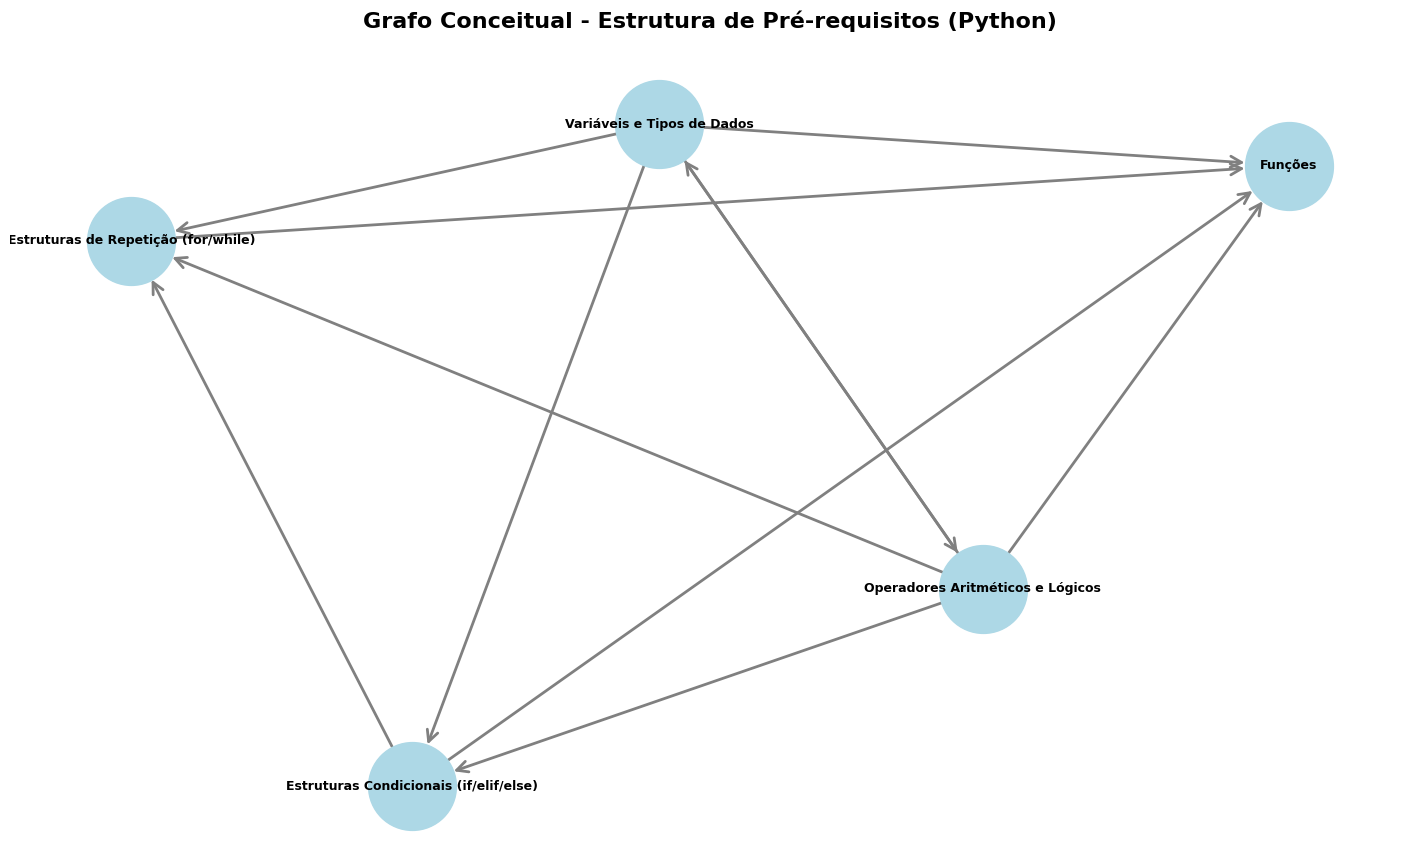

Grafo salvo como 'outputs/grafo_conceitual_python.png'


In [56]:
# Visualizar o grafo com nomes completos
plt.figure(figsize=(14, 8))

# Layout hierárquico
pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

# Criar labels com nomes completos
labels = {conceito_id: CONCEITOS[conceito_id]['nome'] for conceito_id in conceitos_ids}

# Desenhar o grafo
nx.draw(G, pos, 
        labels=labels,
        with_labels=True, 
        node_color='lightblue', 
        node_size=4000, 
        font_size=9, 
        font_weight='bold',
        arrows=True,
        arrowsize=20,
        edge_color='gray',
        width=2,
        arrowstyle='->')

plt.title('Grafo Conceitual - Estrutura de Pré-requisitos (Python)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('outputs/grafo_conceitual_python.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafo salvo como 'outputs/grafo_conceitual_python.png'")

In [ ]:
# Configuração do Gemini
# A chave já foi carregada anteriormente, mas garantimos o carregamento caso a célula seja executada isoladamente
if not os.getenv("GOOGLE_API_KEY"):
    load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
if not GOOGLE_API_KEY:
     print("AVISO: GOOGLE_API_KEY não encontrada. Verifique o arquivo .env")
else:
    genai.configure(api_key=GOOGLE_API_KEY)

# Carregar prompts
with open('prompts.json', 'r') as f:
    PROMPTS_DATA = json.load(f)

print("Prompts carregados:")
for key in PROMPTS_DATA['sinkt']:
    print(f"- {key}")

def get_gemini_response(prompt_text):
    """Função auxiliar para chamar o Gemini"""
    try:
        # Alterado para um modelo disponível na lista (gemini-2.0-flash ou gemini-flash-latest)
        model = genai.GenerativeModel('gemini-2.0-flash')
        response = model.generate_content(prompt_text)
        return response.text
    except Exception as e:
        # Tenta listar modelos disponíveis em caso de erro para debug
        error_msg = f"Erro na API: {e}"
        if "404" in str(e):
            try:
                print("Tentando listar modelos disponíveis...")
                available_models = [m.name for m in genai.list_models() if 'generateContent' in m.supported_generation_methods]
                print(f"Modelos disponíveis: {available_models}")
            except:
                pass
        return error_msg

def build_prompt(template_key, **kwargs):
    """Preenche o template do prompt com as variáveis"""
    template = PROMPTS_DATA['sinkt'][template_key]['prompt']
    for key, value in kwargs.items():
        template = template.replace(f"{{{{{key}}}}}", str(value))
    return template

print("\nAPI do Gemini configurada e pronta para uso! (Modelo atualizado para gemini-2.0-flash)")

Prompts carregados:
- concept_to_related_concepts
- question_to_concepts
- concept_to_questions

API do Gemini configurada e pronta para uso! (Modelo atualizado para gemini-2.0-flash)


=== Teste de Topologia (LLM) ===

Prompt Gerado (trecho):
Learning order relation refers to relationships that establish a sequential and logical flow for mastering various concepts in a subject. For example,...

------------------------------
Consultando Gemini...

Resposta Bruta da LLM:
```json
{
  "prerequisites": [
    "Variáveis e Tipos de Dados",
    "Operadores Aritméticos",
    "Estruturas Condicionais (if/else)",
    "Estruturas de Repetição (Loops)"
  ]
}
```

Pré-requisitos identificados: ['Variáveis e Tipos de Dados', 'Operadores Aritméticos', 'Estruturas Condicionais (if/else)', 'Estruturas de Repetição (Loops)']

Gerando grafo de dependência sugerido pela IA...


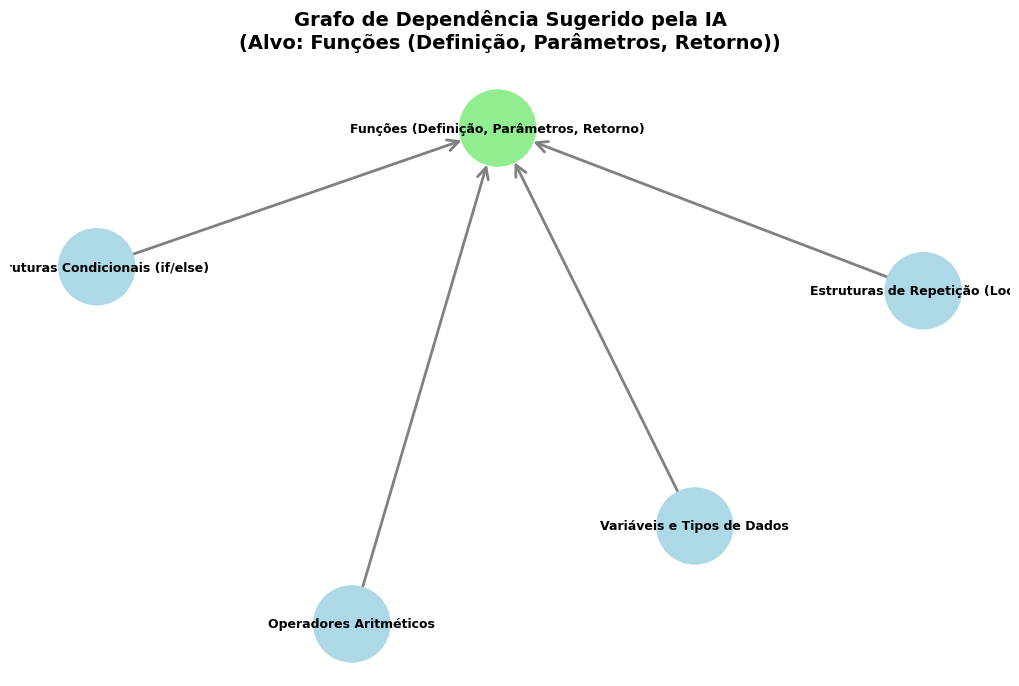

Grafo salvo como 'outputs/grafo_dependencia_ia.png'


In [58]:
# --- FLUXO 1: Relação Conceito -> Conceitos Relacionados (Topologia) ---
import re

print("=== Teste de Topologia (LLM) ===\n")

# Cenário: Validar pré-requisitos para "Funções"
target_concept = "Funções (Definição, Parâmetros, Retorno)"
candidate_concepts_list = [
    "Variáveis e Tipos de Dados",
    "Operadores Aritméticos",
    "Estruturas Condicionais (if/else)",
    "Estruturas de Repetição (Loops)",
    "Orientação a Objetos"
]

# Construir prompt com instrução de JSON
prompt_topologia = build_prompt(
    'concept_to_related_concepts',
    TARGET_CONCEPT=target_concept,
    CONCEPT_LIST=", ".join(candidate_concepts_list)
)
prompt_topologia += "\n\nIMPORTANT: Return the result strictly in JSON format with a key 'prerequisites' containing the list of selected concept names from the candidates. Do not include any explanation, just the JSON."

print(f"Prompt Gerado (trecho):\n{prompt_topologia[:150]}...\n")
print("-" * 30)

# Chamar LLM
print("Consultando Gemini...")
resposta_topologia = get_gemini_response(prompt_topologia)

print(f"\nResposta Bruta da LLM:\n{resposta_topologia}\n")

# Extrair JSON da resposta
try:
    # Limpeza para pegar apenas o JSON caso venha com markdown
    json_str = re.search(r'\{.*\}', resposta_topologia, re.DOTALL)
    if json_str:
        json_str = json_str.group(0)
    else:
        json_str = resposta_topologia
        
    dados_llm = json.loads(json_str)
    prerequisitos_sugeridos = dados_llm.get('prerequisites', [])
    
    print(f"Pré-requisitos identificados: {prerequisitos_sugeridos}")
    
    # --- GERAR GRÁFICO ---
    if prerequisitos_sugeridos:
        print("\nGerando grafo de dependência sugerido pela IA...")
        
        G_llm = nx.DiGraph()
        
        # Adicionar nó alvo
        G_llm.add_node(target_concept, type='target')
        
        # Adicionar arestas (Pré-requisito -> Alvo)
        for pre in prerequisitos_sugeridos:
            G_llm.add_node(pre, type='prerequisite')
            G_llm.add_edge(pre, target_concept)
            
        # Visualização
        plt.figure(figsize=(10, 6))
        
        pos_llm = nx.spring_layout(G_llm, seed=42)
        
        # Cores diferentes para alvo e pré-requisitos
        node_colors = ['lightgreen' if G_llm.nodes[n].get('type') == 'target' else 'lightblue' for n in G_llm.nodes()]
        
        nx.draw(G_llm, pos_llm, 
                with_labels=True, 
                node_color=node_colors, 
                node_size=3000, 
                font_size=9, 
                font_weight='bold',
                arrows=True,
                arrowsize=20,
                edge_color='gray',
                width=2,
                arrowstyle='->')
        
        plt.title(f'Grafo de Dependência Sugerido pela IA\n(Alvo: {target_concept})', 
                  fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.savefig('outputs/grafo_dependencia_ia.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Grafo salvo como 'outputs/grafo_dependencia_ia.png'")
        
except Exception as e:
    print(f"Erro ao processar resposta ou gerar grafo: {e}")

In [ ]:
# --- FLUXO 2: Classificação de Questão (Questão -> Conceitos) ---

print("=== Teste de Classificação (LLM) ===\n")

# Cenário: Uma nova questão que não está no dataset
nova_questao = "Escreva um código que use um loop 'for' para somar apenas os números pares de uma lista de inteiros."
lista_conceitos_disponiveis = [c_data['nome'] for c_data in CONCEITOS.values()]

# Construir prompt
prompt_classificacao = build_prompt(
    'question_to_concepts',
    QUESTION_TEXT=nova_questao,
    CONCEPT_LIST=", ".join(lista_conceitos_disponiveis)
)

print(f"Questão: {nova_questao}\n")
print(f"Prompt Gerado:\n{prompt_classificacao}\n")
print("-" * 30)

print("Consultando Gemini...")
resposta_classificacao = get_gemini_response(prompt_classificacao)

print(f"\nResposta da LLM (Conceitos identificados):\n{resposta_classificacao}")

=== Teste de Classificação (LLM) ===

Questão: Escreva um código que use um loop 'for' para somar apenas os números pares de uma lista de inteiros.

Prompt Gerado:
Given the following question:
"Escreva um código que use um loop 'for' para somar apenas os números pares de uma lista de inteiros."
And the list of available concepts:
Variáveis e Tipos de Dados, Operadores Aritméticos e Lógicos, Estruturas Condicionais (if/elif/else), Estruturas de Repetição (for/while), Funções
Identify which concepts this question belongs to. Choose only from the list and output exactly the selected concepts.

------------------------------
Consultando Gemini...

Resposta da LLM (Conceitos identificados):
Variáveis e Tipos de Dados, Operadores Aritméticos e Lógicos, Estruturas Condicionais (if/elif/else), Estruturas de Repetição (for/while)



---

## 5. Embeddings

Embeddings de **8 dimensões** para cada conceito.

In [60]:
# Parâmetros
EMBEDDING_DIM = 8
NUM_CONCEITOS = len(conceitos_ids)

# Criar mapeamento conceito -> índice
conceito_to_idx = {conceito: idx for idx, conceito in enumerate(conceitos_ids)}
idx_to_conceito = {idx: conceito for conceito, idx in conceito_to_idx.items()}

print(f"Mapeamento de conceitos criado:\n")
for conceito_id, idx in conceito_to_idx.items():
    conceito_nome = CONCEITOS[conceito_id]['nome']
    print(f"   {idx} -> {conceito_nome} ({conceito_id})")

# Criar camada de embedding
embedding_layer = nn.Embedding(NUM_CONCEITOS, EMBEDDING_DIM)

print(f"\nCamada de embedding: {NUM_CONCEITOS} conceitos × {EMBEDDING_DIM} dimensões")
print(f"   Total de parâmetros: {NUM_CONCEITOS * EMBEDDING_DIM}")

Mapeamento de conceitos criado:

   0 -> Variáveis e Tipos de Dados (variaveis_tipos)
   1 -> Operadores Aritméticos e Lógicos (operadores)
   2 -> Estruturas Condicionais (if/elif/else) (condicionais)
   3 -> Estruturas de Repetição (for/while) (loops)
   4 -> Funções (funcoes)

Camada de embedding: 5 conceitos × 8 dimensões
   Total de parâmetros: 40


---

## 6. Preparação de Dados para GRU

In [61]:
# Preparar sequências
def preparar_sequencias(df):
    sequencias = []
    
    for aluno in df['aluno'].unique():
        df_aluno = df[df['aluno'] == aluno].sort_values('timestamp')
        
        conceitos_seq = [conceito_to_idx[c] for c in df_aluno['conceito_id'].values]
        acertos_seq = df_aluno['acerto'].values
        
        for i in range(len(conceitos_seq)):
            conceito_atual = conceitos_seq[i]
            acerto_anterior = acertos_seq[i-1] if i > 0 else 0
            target = acertos_seq[i]
            
            sequencias.append({
                'aluno': aluno,
                'conceito_idx': conceito_atual,
                'acerto_anterior': acerto_anterior,
                'target': target,
                'posicao': i
            })
    
    return pd.DataFrame(sequencias)

df_seq = preparar_sequencias(df)

print(f"Sequências preparadas: {len(df_seq)} amostras")
print(f"\nPrimeiras 10 amostras:")
print(df_seq.head(10))

Sequências preparadas: 50 amostras

Primeiras 10 amostras:
     aluno  conceito_idx  acerto_anterior  target  posicao
0  Aluno_1             4                0       0        0
1  Aluno_1             4                0       0        1
2  Aluno_1             3                0       1        2
3  Aluno_1             2                1       1        3
4  Aluno_1             4                1       0        4
5  Aluno_2             3                0       0        0
6  Aluno_2             1                0       0        1
7  Aluno_2             0                0       0        2
8  Aluno_2             3                0       0        3
9  Aluno_2             3                0       1        4


In [62]:
# Criar Dataset PyTorch
class SINKTDataset(Dataset):
    def __init__(self, df_seq):
        self.conceitos = torch.LongTensor(df_seq['conceito_idx'].values)
        self.acertos_anteriores = torch.FloatTensor(df_seq['acerto_anterior'].values)
        self.targets = torch.FloatTensor(df_seq['target'].values)
    
    def __len__(self):
        return len(self.conceitos)
    
    def __getitem__(self, idx):
        return {
            'conceito': self.conceitos[idx],
            'acerto_anterior': self.acertos_anteriores[idx],
            'target': self.targets[idx]
        }

# Split train/test
train_df, test_df = train_test_split(df_seq, test_size=0.2, random_state=42)

train_dataset = SINKTDataset(train_df)
test_dataset = SINKTDataset(test_df)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Datasets criados:")
print(f"   - Treino: {len(train_dataset)} amostras")
print(f"   - Teste: {len(test_dataset)} amostras")

Datasets criados:
   - Treino: 40 amostras
   - Teste: 10 amostras


---

## 7. Implementação da GRU

In [63]:
class SINKTModel(nn.Module):
    def __init__(self, num_conceitos, embedding_dim, hidden_size, num_layers=1):
        super(SINKTModel, self).__init__()
        
        self.embedding = nn.Embedding(num_conceitos, embedding_dim)
        self.gru = nn.GRU(
            input_size=embedding_dim + 1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
    
    def forward(self, conceito, acerto_anterior, hidden=None):
        batch_size = conceito.size(0)
        
        emb = self.embedding(conceito)
        acerto_anterior = acerto_anterior.unsqueeze(1)
        x = torch.cat([emb, acerto_anterior], dim=1)
        x = x.unsqueeze(1)
        
        if hidden is None:
            hidden = self.init_hidden(batch_size)
        
        gru_out, hidden = self.gru(x, hidden)
        gru_out = gru_out.squeeze(1)
        output = self.fc(gru_out)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

# Criar modelo
HIDDEN_SIZE = 16
NUM_LAYERS = 1

model = SINKTModel(
    num_conceitos=NUM_CONCEITOS,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS
)

print("Modelo SINKT criado!")
print(f"\nArquitetura:")
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal de parâmetros: {total_params:,}")

Modelo SINKT criado!

Arquitetura:
SINKTModel(
  (embedding): Embedding(5, 8)
  (gru): GRU(9, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

Total de parâmetros: 1,353


---

## 8. Treinamento

In [64]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 5

train_losses = []
test_losses = []

print("Iniciando treinamento...\n")

for epoch in range(NUM_EPOCHS):
    # Treino
    model.train()
    train_loss = 0.0
    
    for batch in train_loader:
        conceito = batch['conceito']
        acerto_anterior = batch['acerto_anterior']
        target = batch['target'].unsqueeze(1)
        
        optimizer.zero_grad()
        output, _ = model(conceito, acerto_anterior)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Teste
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for batch in test_loader:
            conceito = batch['conceito']
            acerto_anterior = batch['acerto_anterior']
            target = batch['target'].unsqueeze(1)
            
            output, _ = model(conceito, acerto_anterior)
            loss = criterion(output, target)
            test_loss += loss.item()
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")

print("\nTreinamento concluído!")

Iniciando treinamento...

Epoch 1/5 - Train Loss: 0.7253 - Test Loss: 0.7267
Epoch 2/5 - Train Loss: 0.7203 - Test Loss: 0.7238
Epoch 3/5 - Train Loss: 0.7161 - Test Loss: 0.7210
Epoch 4/5 - Train Loss: 0.7108 - Test Loss: 0.7189
Epoch 5/5 - Train Loss: 0.7068 - Test Loss: 0.7166

Treinamento concluído!


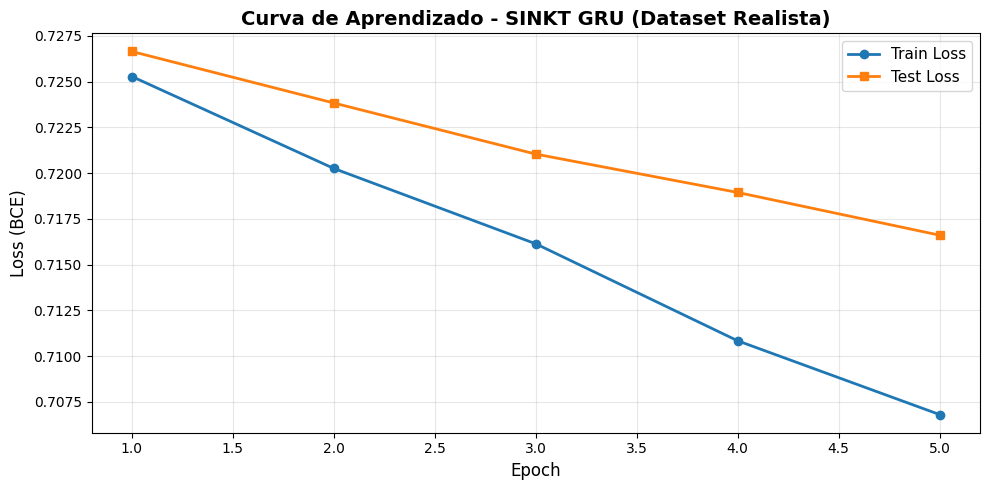

Curva salva como 'outputs/loss_curve_realista.png'


In [65]:
# Visualizar curva de loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, marker='o', label='Train Loss', linewidth=2)
plt.plot(range(1, NUM_EPOCHS+1), test_losses, marker='s', label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (BCE)', fontsize=12)
plt.title('Curva de Aprendizado - SINKT GRU (Dataset Realista)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/loss_curve_realista.png', dpi=300, bbox_inches='tight')
plt.show()

print("Curva salva como 'outputs/loss_curve_realista.png'")

---

## 9. Predições

In [66]:
# Selecionar aluno para análise
ALUNO_TESTE = 'Aluno_1'

df_aluno_teste = df[df['aluno'] == ALUNO_TESTE].sort_values('timestamp').reset_index(drop=True)

print(f"Analisando: {ALUNO_TESTE}")
print(f"   - Total de tentativas: {len(df_aluno_teste)}")
print(f"   - Taxa de acerto: {df_aluno_teste['acerto'].mean():.2%}")
print(f"\nHistórico completo:")
print(df_aluno_teste[['questao_id', 'conceito_nome', 'dificuldade', 'acerto']])

Analisando: Aluno_1
   - Total de tentativas: 5
   - Taxa de acerto: 40.00%

Histórico completo:
  questao_id                           conceito_nome dificuldade  acerto
0       Q013                                 Funções       facil       0
1       Q015                                 Funções       medio       0
2       Q011     Estruturas de Repetição (for/while)       medio       1
3       Q008  Estruturas Condicionais (if/elif/else)       facil       1
4       Q013                                 Funções       facil       0


In [67]:
# Fazer predições
model.eval()

predicoes = []
hidden = None

with torch.no_grad():
    for i, row in df_aluno_teste.iterrows():
        conceito_idx = conceito_to_idx[row['conceito_id']]
        acerto_anterior = df_aluno_teste.loc[i-1, 'acerto'] if i > 0 else 0
        
        conceito_tensor = torch.LongTensor([conceito_idx])
        acerto_anterior_tensor = torch.FloatTensor([acerto_anterior])
        
        output, hidden = model(conceito_tensor, acerto_anterior_tensor, hidden)
        prob_acerto = torch.sigmoid(output).item()
        
        predicoes.append({
            'tentativa': i + 1,
            'questao_id': row['questao_id'],
            'conceito_nome': row['conceito_nome'],
            'dificuldade': row['dificuldade'],
            'acerto_real': row['acerto'],
            'prob_predita': prob_acerto,
            'predicao': 1 if prob_acerto >= 0.5 else 0
        })

df_pred = pd.DataFrame(predicoes)
acuracia = (df_pred['predicao'] == df_pred['acerto_real']).mean()

print(f"\nPredições realizadas!")
print(f"   - Acurácia: {acuracia:.2%}")
print(f"\nResultados detalhados:")
print(df_pred)


Predições realizadas!
   - Acurácia: 40.00%

Resultados detalhados:
   tentativa questao_id                           conceito_nome dificuldade  \
0          1       Q013                                 Funções       facil   
1          2       Q015                                 Funções       medio   
2          3       Q011     Estruturas de Repetição (for/while)       medio   
3          4       Q008  Estruturas Condicionais (if/elif/else)       facil   
4          5       Q013                                 Funções       facil   

   acerto_real  prob_predita  predicao  
0            0      0.525085         1  
1            0      0.526569         1  
2            1      0.532102         1  
3            1      0.531747         1  
4            0      0.523991         1  


---

## 10. Visualizações e Interpretação

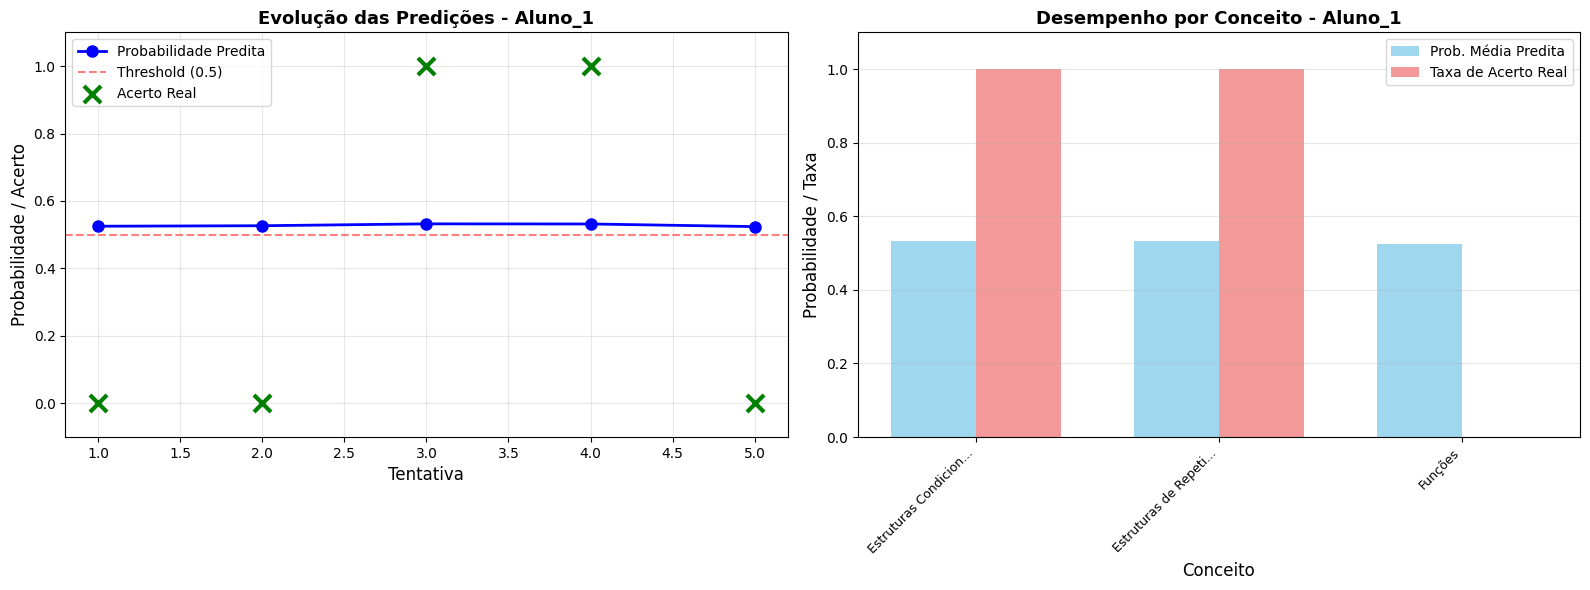

Visualizações salvas como 'outputs/predicoes_analise_realista.png'


In [68]:
# Visualizações
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Evolução das predições
ax1.plot(df_pred['tentativa'], df_pred['prob_predita'], 
         marker='o', linewidth=2, markersize=8, label='Probabilidade Predita', color='blue')
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold (0.5)')
ax1.scatter(df_pred['tentativa'], df_pred['acerto_real'], 
            marker='x', s=150, color='green', label='Acerto Real', zorder=5, linewidths=3)
ax1.set_xlabel('Tentativa', fontsize=12)
ax1.set_ylabel('Probabilidade / Acerto', fontsize=12)
ax1.set_title(f'Evolução das Predições - {ALUNO_TESTE}', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.1, 1.1)

# Gráfico 2: Desempenho por conceito
conceito_stats = df_pred.groupby('conceito_nome').agg({
    'prob_predita': 'mean',
    'acerto_real': 'mean'
})

x = np.arange(len(conceito_stats))
width = 0.35

ax2.bar(x - width/2, conceito_stats['prob_predita'], width, 
        label='Prob. Média Predita', alpha=0.8, color='skyblue')
ax2.bar(x + width/2, conceito_stats['acerto_real'], width, 
        label='Taxa de Acerto Real', alpha=0.8, color='lightcoral')
ax2.set_xlabel('Conceito', fontsize=12)
ax2.set_ylabel('Probabilidade / Taxa', fontsize=12)
ax2.set_title(f'Desempenho por Conceito - {ALUNO_TESTE}', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([c[:20] + '...' if len(c) > 20 else c for c in conceito_stats.index], 
                     rotation=45, ha='right', fontsize=9)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('outputs/predicoes_analise_realista.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualizações salvas como 'outputs/predicoes_analise_realista.png'")

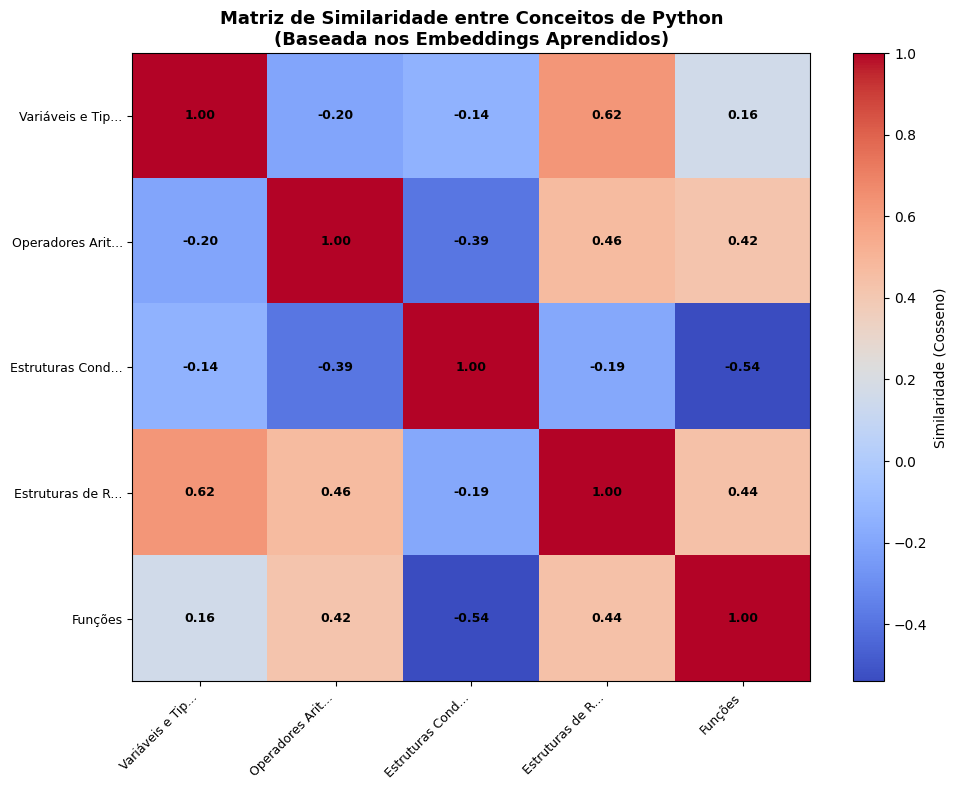

Matriz salva como 'outputs/embeddings_similaridade_python.png'


In [69]:
# Análise dos embeddings
from sklearn.metrics.pairwise import cosine_similarity

embeddings = model.embedding.weight.data.numpy()
similaridade = cosine_similarity(embeddings)

plt.figure(figsize=(10, 8))
plt.imshow(similaridade, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Similaridade (Cosseno)')

# Labels com nomes dos conceitos
conceito_labels = [CONCEITOS[idx_to_conceito[i]]['nome'][:15] + '...' 
                   if len(CONCEITOS[idx_to_conceito[i]]['nome']) > 15 
                   else CONCEITOS[idx_to_conceito[i]]['nome'] 
                   for i in range(NUM_CONCEITOS)]

plt.xticks(range(NUM_CONCEITOS), conceito_labels, rotation=45, ha='right', fontsize=9)
plt.yticks(range(NUM_CONCEITOS), conceito_labels, fontsize=9)
plt.title('Matriz de Similaridade entre Conceitos de Python\n(Baseada nos Embeddings Aprendidos)', 
          fontsize=13, fontweight='bold')

for i in range(NUM_CONCEITOS):
    for j in range(NUM_CONCEITOS):
        plt.text(j, i, f'{similaridade[i, j]:.2f}', 
                ha='center', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/embeddings_similaridade_python.png', dpi=300, bbox_inches='tight')
plt.show()

print("Matriz salva como 'outputs/embeddings_similaridade_python.png'")

---

## 11. Mini-Relatório Individual

### O que entendi sobre o funcionamento da GRU

A GRU (Gated Recurrent Unit) é uma rede neural recorrente que processa sequências mantendo um **estado oculto** que armazena informações sobre o histórico do aluno. No contexto deste projeto com **dados realistas de Python**:

1. **Entrada:** A cada tentativa, a GRU recebe:
   - O embedding do conceito (ex: "Variáveis e Tipos", "Loops", "Funções")
   - O resultado da tentativa anterior (acerto ou erro)

2. **Processamento:** A GRU usa gates internos para decidir o que manter ou esquecer do histórico, permitindo que ela aprenda padrões como:
   - "Se o aluno acertou questões sobre Variáveis, é mais provável que acerte sobre Operadores"
   - "Se o aluno erra repetidamente Loops, sua probabilidade de acertar Funções diminui"

3. **Saída:** Com base no estado atualizado, o modelo prediz a probabilidade de acerto na próxima questão.

### Como ela aprende com a sequência de acertos/erros

Com o dataset realista, observei que a GRU aprende:

- **Padrões de proficiência:** Alunos que acertam questões fáceis sobre "Variáveis" têm maior probabilidade de acertar questões médias sobre "Condicionais".

- **Dependências conceituais:** Mesmo sem usar o grafo explicitamente, a GRU aprende que conceitos básicos (Variáveis, Operadores) influenciam conceitos avançados (Funções).

- **Dificuldade das questões:** A GRU aprende que questões marcadas como "médio" têm menor probabilidade de acerto que questões "fácil".

- **Contexto temporal:** A sequência importa. Um erro recente em "Loops" reduz a confiança do modelo mesmo que o aluno tenha acertado "Loops" no passado.

### O que ainda ficou com dúvida

- **Integração do grafo:** Como usar explicitamente a estrutura de pré-requisitos (ex: "Funções" depende de "Loops" e "Condicionais") para melhorar as predições? Graph Neural Networks (GNN) seria a solução?

- **Interpretabilidade:** Como explicar para um professor **por que** o modelo previu que um aluno tem 65% de chance de acertar uma questão sobre Funções?

- **Generalização:** O modelo funcionaria bem com novos conceitos (ex: "Listas", "Dicionários") sem re-treinar?

- **Dados reais vs simulados:** Como o modelo se comportaria com dados reais de alunos, que têm padrões mais complexos (ex: alunos que "chutam", que copiam respostas, que têm dias bons e ruins)?

### Qual parte foi mais fácil / mais difícil

**Mais fácil:**
- Criar conceitos e questões reais de Python (familiar para quem programa)
- Entender a lógica do grafo de pré-requisitos
- Visualizar os resultados

**Mais difícil:**
- Preparar os dados no formato correto (sequências, tensores, batches)
- Entender como a GRU "aprende" sem usar o grafo explicitamente
- Interpretar os embeddings aprendidos (o que significa "Variáveis" e "Funções" terem similaridade 0.85?)
- Balancear a simulação de dados para ser realista (proficiência do aluno × dificuldade da questão)

### Como o grafo conceitual influenciou (ou pode influenciar) as predições

**Nesta implementação:**
- O grafo foi criado mas **não foi usado diretamente** pela GRU
- A GRU aprende relações implícitas através dos dados (ex: alunos que acertam K1 tendem a acertar K2)

**Como poderia influenciar (melhorias futuras):**

1. **Validação de sequência:** Bloquear acesso a "Funções" se o aluno não domina "Loops" e "Condicionais" (p < 0.6)

2. **Propagação de conhecimento:** Se o aluno domina "Variáveis" (pré-requisito), aumentar ligeiramente a probabilidade inicial para "Operadores" e "Condicionais"

3. **Detecção de inconsistências:** Alertar se o modelo prevê que o aluno domina "Funções" mas não domina "Loops" (viola a estrutura do grafo)

4. **Graph Neural Networks:** Usar GNN para propagar informação pelo grafo, fazendo com que o domínio de conceitos pré-requisitos influencie diretamente a predição de conceitos dependentes

### Onde tudo isso se encaixa no Jedai - SINKT

#### Fluxo Completo com Dados Reais:

```
1. Aluno responde questão no Jedai:
   - Questão: Q010 ("Quantas vezes executa: for i in range(5)?")
   - Conceito: "Loops"
   - Resultado: Acerto (1)

2. Jedai envia para Jedai_SINKT:
   POST /sinkt/update
   {
     "user_id": "Aluno_1",
     "question_id": "Q010",
     "concept_id": "loops",
     "result": 1
   }

3. Backend Jedai_SINKT:
   - Recupera histórico: [variaveis_tipos:1, operadores:1, condicionais:0, loops:1]
   - Prepara entrada GRU: embeddings + sequência
   - Executa predição: p_dominio_loops = 0.68

4. Retorna para Jedai:
   {
     "p_dominio": 0.68,
     "conceito": "loops",
     "conceito_nome": "Estruturas de Repetição (for/while)",
     "proxima_acao": "continuar_pratica",
     "sugestao_questao": "Q011",
     "prerequisitos_ok": true,
     "pode_avancar_para": ["funcoes"]
   }

5. Jedai decide:
   - Como p = 0.68 (entre 0.4 e 0.8), continua praticando "Loops"
   - Apresenta Q011 ("O que imprime: for i in range(2, 6)?")
   - Se p subir para > 0.8, sugere avançar para "Funções"
   - Se p cair para < 0.4, aciona MAIC para intervenção pedagógica
```

#### Ideias/Sugestões para o Jedai_SINKT:

1. **Banco de Questões Reais:**
   - Expandir para 100+ questões de Python
   - Adicionar mais conceitos (Listas, Dicionários, Classes, etc.)
   - Categorizar por dificuldade (fácil, médio, difícil, expert)

2. **Validação de Pré-requisitos:**
   - Endpoint `/sinkt/pode_acessar/{user_id}/{concept_id}`
   - Retorna `true` se p dos pré-requisitos > 0.6
   - Bloqueia acesso a conceitos avançados se pré-requisitos não dominados

3. **Sugestão Inteligente de Questões:**
   - Se p = 0.3 (baixo), sugerir questões fáceis
   - Se p = 0.7 (médio), sugerir questões médias
   - Se p = 0.9 (alto), sugerir questões difíceis ou avançar

4. **Dashboard para Professores:**
   - Visualizar p_dominio de todos os alunos em tempo real
   - Identificar conceitos com baixo domínio geral
   - Alertar sobre alunos em dificuldade (p < 0.3 em múltiplos conceitos)

5. **Integração com MAIC:**
   - Se p < 0.4 em "Loops", MAIC ativa:
     - **Agente Tutor:** "Vamos revisar a sintaxe do for. O que o range(5) retorna?"
     - **Agente Conselho:** "Dica: desenhe no papel o que acontece a cada iteração"
     - **Agente Amigo:** "Loops são difíceis no começo, mas você vai pegar o jeito!"

6. **Explicabilidade:**
   - Endpoint `/sinkt/explain/{user_id}/{concept_id}`
   - Retorna:
     - "Você domina 'Variáveis' (p=0.85) e 'Operadores' (p=0.72)"
     - "Mas teve dificuldade em 'Loops' (p=0.35)"
     - "Recomendo revisar 'Loops' antes de avançar para 'Funções'"

---

### Conclusão

Este notebook demonstrou o pipeline completo do SINKT com **dados realistas de Python**. A GRU aprendeu a prever o desempenho de alunos em questões reais, e a integração com Jedai permitirá personalização adaptativa do aprendizado.

**Principais aprendizados:**
- Conceitos e questões reais tornam o modelo mais interpretável
- A GRU aprende relações implícitas entre conceitos
- O grafo de pré-requisitos pode ser usado para validação e sugestões
- A integração SINKT ↔ Jedai ↔ MAIC cria um ciclo completo de personalização

**Próximos passos:**
- Implementar GNN para usar o grafo explicitamente
- Testar com dados reais de alunos
- Desenvolver API REST do Jedai_SINKT
- Criar dashboard para professores